<a href="https://colab.research.google.com/github/BELBINBENORM/my_kaggle_ml_practice/blob/main/26.01.00.Predicting_Student_test_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Student Test Scores
---
####Playground Series - Season 6 Episode 1



`Upload Kaggle API key (one-time per session)`

- Go to Kaggle → Account → API → Create New Token
- Download kaggle.json

Now run the below code

In [1]:
# Upload kaggle.json when prompted
from google.colab import files
files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle competitions download -c playground-series-s6e1

# Unzip files
!unzip -o playground-series-s6e1.zip



playground-series-s6e1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  playground-series-s6e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer,make_column_selector
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import  mean_squared_error
from itertools import combinations


In [3]:
raw_train_df=pd.read_csv("train.csv")
raw_test_df=pd.read_csv("test.csv")

## EDA

In [4]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [5]:
raw_df = raw_train_df.drop_duplicates()
X = raw_df.drop(columns=['id','exam_score'])
y = raw_df['exam_score']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)
X_test = raw_test_df.drop(columns=['id'])

num_col = X_train.select_dtypes(include='number').columns
cat_col = X_train.select_dtypes(exclude='number').columns

In [6]:
# Target

y_train.describe()

,exam_score
count,504000.000000
mean,62.482335
std,18.931347
min,19.599000
25%,48.800000
50%,62.500000
75%,76.200000
max,100.000000


<Axes: >

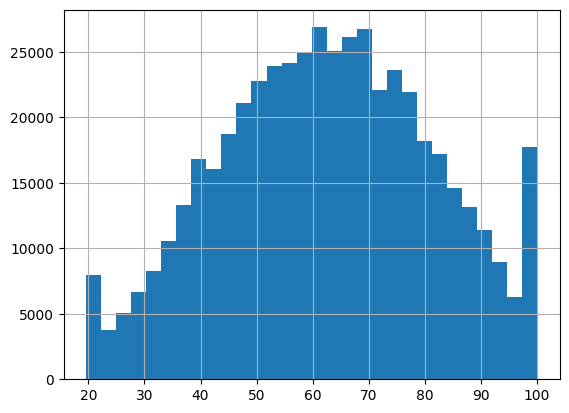

In [7]:
y_train.hist(bins=30)

In [8]:
# Numeric columns

X_train[num_col].describe()

,age,study_hours,class_attendance,sleep_hours
count,504000.000000,504000.000000,504000.000000,504000.000000
mean,20.543137,3.999017,71.983240,7.072504
std,2.260777,2.359695,17.434645,1.744139
min,17.000000,0.080000,40.600000,4.100000
25%,19.000000,1.970000,57.000000,5.600000
50%,21.000000,4.000000,72.600000,7.100000
75%,23.000000,6.050000,87.200000,8.600000
max,24.000000,7.910000,99.400000,9.900000


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'study_hours'}>],
       [<Axes: title={'center': 'class_attendance'}>,
        <Axes: title={'center': 'sleep_hours'}>]], dtype=object)

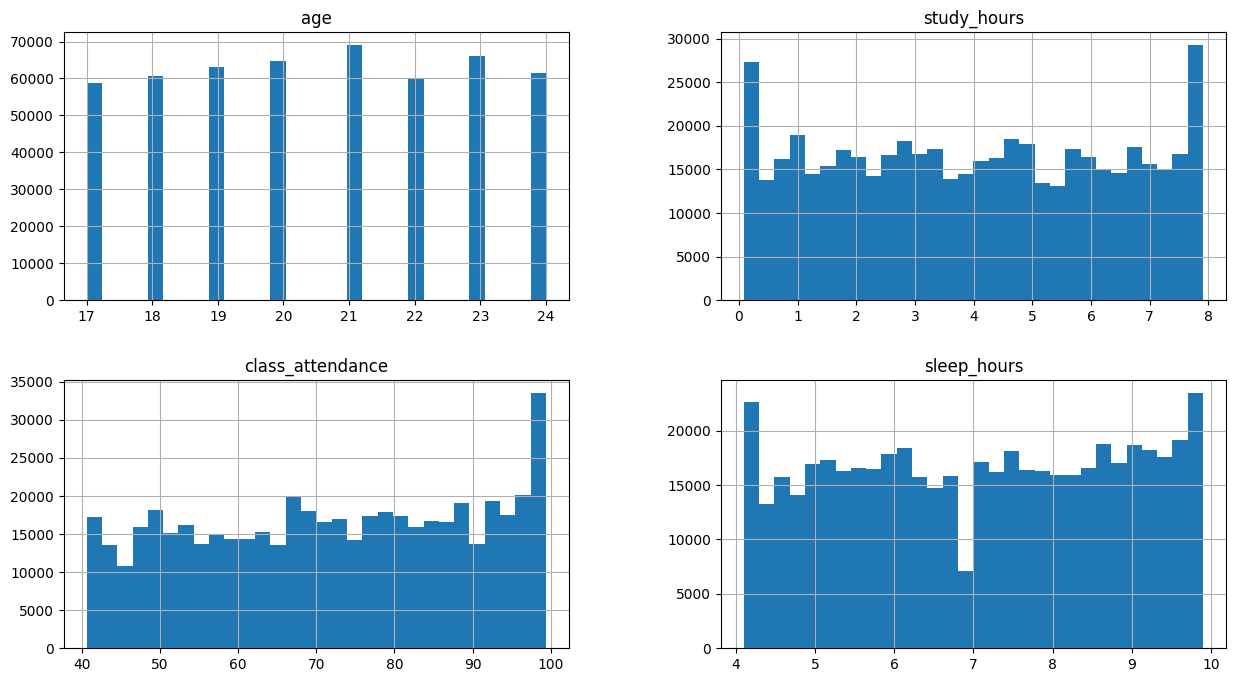

In [9]:
X_train[num_col].hist(bins=30,figsize=(15,8))

In [10]:
X_train[cat_col].describe()

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,504000,504000,504000,504000,504000,504000,504000
unique,3,7,2,3,5,3,3
top,other,b.tech,yes,poor,coaching,medium,moderate
freq,168857,104999,463589,170995,105425,171078,282941


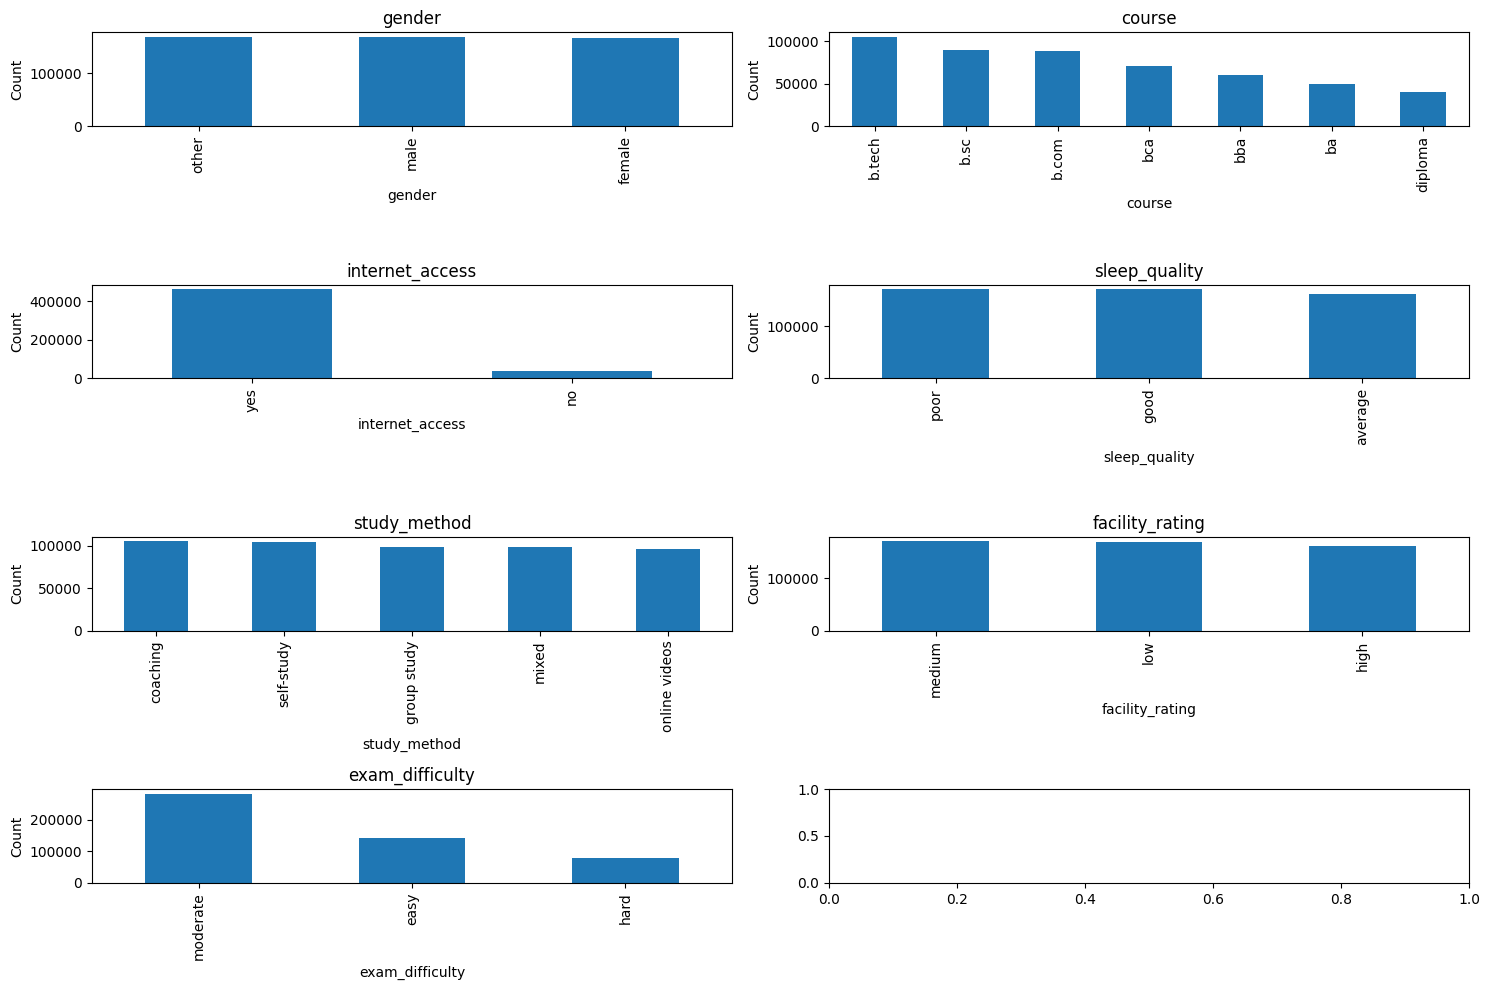

In [11]:

fig,axes = plt.subplots(4,2,figsize=(15,10))
axes = axes.flatten()

for col, ax in zip(cat_col,axes):
  X_train[col].value_counts().plot(ax=ax,kind='bar')
  ax.set_title(col)
  ax.set_xlabel(col)
  ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

## preprocessing

### Feature Enginering

In [12]:
class Featur_Enginering(BaseEstimator, TransformerMixin):
    def __init__(self, base_num_cols, eps=1e-6):
        self.base_num_cols = base_num_cols
        self.eps = eps
        self.feature_names_out_ = None

    def fit(self, X, y=None):

        X_dummy = self.transform(X.iloc[:1])
        self.feature_names_out_ = X_dummy.columns.tolist()
        return self

    def transform(self, X):

        X = X.copy()
        num_features = {}

        # 1. Manual Features
        X["low_sleep"] = (X["sleep_hours"] < 6).astype(int)
        X["very_low_sleep"] = (X["sleep_hours"] < 5).astype(int)
        X["attendance_pressure"] = 1 - X["class_attendance"]
        X["cognitive_load"] = X["study_hours"] / (X["sleep_hours"] + 1)
        X['eff__attendance_weighted_study'] = X['study_hours'] / (100 - X['class_attendance'] + self.eps)
        X['ratio__rest_balance'] = X['sleep_hours'] - (X['study_hours'] / 7)
        X['flag__high_burnout'] = ((X['study_hours'] > 15) & (X['sleep_hours'] < 5)).astype(int)

        X["age_group"] = pd.cut(X["age"],
                                bins=[0, 18, 22, 30, 100],
                                labels=["school", "college", "postgrad", "adult"])

        # 2. Polynomial features
        for c in self.base_num_cols:
            num_features[f"{c}__sq"] = X[c] ** 2

        # 3. Pairwise interactions

        for c1, c2 in combinations(self.base_num_cols, 2):
            num_features[f"{c1}__x__{c2}"] = X[c1] * X[c2]
            num_features[f"{c1}__minus__{c2}"] = X[c1] - X[c2]
            num_features[f"{c2}__minus__{c1}"] = X[c2] - X[c1]
            num_features[f"{c1}__div__{c2}"] = X[c1] / (X[c2] + self.eps)
            num_features[f"{c2}__div__{c1}"] = X[c2] / (X[c1] + self.eps)

        X = pd.concat([X, pd.DataFrame(num_features, index=X.index)], axis=1)
        return X

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_out_ is None:
            raise ValueError("The transformer must be fitted before calling get_feature_names_out.")
        return np.array(self.feature_names_out_)

### Imputer, Scaler, and Enconder

In [13]:
num_normalizer = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
     ("Normalizer",StandardScaler())
])

cat_normalizer = Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
     ("Normalizer",OneHotEncoder(handle_unknown="ignore",sparse_output=False))
])

normalizer = ColumnTransformer([
    ("num",num_normalizer,make_column_selector(dtype_include=np.number)),
     ("cat",cat_normalizer,make_column_selector(dtype_exclude=np.number))
])

### Pipeline - Preprocessor

In [14]:
num_cols = ['age', 'study_hours', 'class_attendance', 'sleep_hours','flag__high_burnout','ratio__rest_balance','eff__attendance_weighted_study',"cognitive_load","attendance_pressure","very_low_sleep","low_sleep"]

In [18]:

Preprocessor = Pipeline(steps=[
    ("Feature Enginering",Featur_Enginering(num_cols,1e-6)),
     ("Normalizer",normalizer)
])

#Preprocessor.set_output(transform="pandas")

### Features Selection

In [16]:
Preprocessor.fit(X_train, y_train)

feature_names = Preprocessor.get_feature_names_out()
len(feature_names)


326

In [16]:
X_train_p=Preprocessor.fit_transform(X_train)
X_val_p =Preprocessor.transform(X_val)

#### Model Training

In [17]:
Model = HistGradientBoostingRegressor(max_depth=6,learning_rate=0.05,max_iter=300,random_state=42)
#Model = ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=5000, random_state=42)
#Model = Lasso(alpha=0.001, max_iter=5000, random_state=42)
#Model = Ridge(alpha=np.float64(1.0))

In [19]:
Model.fit(X_train_p,y_train)

HistGradientBoostingRegressor(learning_rate=0.05, max_depth=6, max_iter=300,
                              random_state=42)

In [19]:
import joblib
joblib.dump(Model, '004_HGB_model.pkl')

print("Model and Preprocessor saved successfully!")

Model and Preprocessor saved successfully!


#### Permutation Importance

In [33]:
from sklearn.inspection import permutation_importance

feature_names = Final_pipe.named_steps['Preprocessor'].get_feature_names_out()

result = permutation_importance(
    Final_pipe, X_val, y_val, n_repeats=1, random_state=42, n_jobs=-1
)


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [34]:
# results
perm_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

ValueError: All arrays must be of the same length

In [35]:
result.importances_mean

array([2.50291720e-04, 5.54486181e-05, 1.36960130e-04, 1.01839621e+00,
       1.66219782e-01, 1.09559249e-06, 3.01108622e-02, 7.54830371e-02,
       6.26195347e-02, 4.96397509e-02, 1.17502234e-06])

In [31]:
perm_imp_df.to_csv("perm_imp_df.csv")

In [22]:
print(perm_imp_df.head(20))

                                      Feature  Importance_Mean  Importance_Std
30      num__study_hours__x__class_attendance         0.476412        0.002199
8         num__eff__attendance_weighted_study         0.055134        0.000453
35           num__study_hours__x__sleep_hours         0.052072        0.000565
60                 cat__study_method_coaching         0.044107        0.000369
59                    cat__sleep_quality_poor         0.027534        0.000192
58                    cat__sleep_quality_good         0.022874        0.000252
66                   cat__facility_rating_low         0.017288        0.000316
65                  cat__facility_rating_high         0.016147        0.000231
40      num__class_attendance__x__sleep_hours         0.012456        0.000244
1                            num__study_hours         0.012092        0.000216
62                    cat__study_method_mixed         0.005683        0.000111
64               cat__study_method_self-study       

#### Features Selection

In [23]:

perm_imp_sorted = perm_imp_df.sort_values('Importance_Mean', ascending=False)

perm_imp_sorted['cumulative'] = perm_imp_sorted['Importance_Mean'].cumsum()
total_imp = perm_imp_sorted['Importance_Mean'].sum()

selected_features = perm_imp_sorted[perm_imp_sorted['cumulative'] <= (total_imp * 0.99)]['Feature'].tolist()total_imp

In [ ]:
selected_features

selected_features = ['num__study_hours__x__class_attendance',
 'num__eff__attendance_weighted_study',
 'num__study_hours__x__sleep_hours',
 'cat__study_method_coaching',
 'cat__sleep_quality_poor',
 'cat__sleep_quality_good',
 'cat__facility_rating_low',
 'cat__facility_rating_high',
 'num__class_attendance__x__sleep_hours',
 'num__study_hours',
 'cat__study_method_mixed',
 'cat__study_method_self-study']

### Monotonic Constraints

In [16]:
selected_features = ['num__study_hours__x__class_attendance', 'num__eff__attendance_weighted_study',
                     'num__study_hours__x__sleep_hours', 'cat__study_method_coaching',
                     'cat__sleep_quality_poor', 'cat__sleep_quality_good',
                     'cat__facility_rating_low', 'cat__facility_rating_high',
                     'num__class_attendance__x__sleep_hours', 'num__study_hours',
                     'cat__study_method_mixed', 'cat__study_method_self-study']

In [24]:
constraints = []

for name in selected_features:

    if any(x in name for x in ['study_hours', 'class_attendance', 'sleep_hours']):
        constraints.append(1)

    elif any(x in name for x in ['low_sleep', 'pressure', 'cognitive_load']):
        constraints.append(-1)

    else:
        constraints.append(0)


In [25]:
constraints= tuple(constraints)

### Features selector ..

In [22]:

selector = ColumnTransformer([
    ('keep_best', 'passthrough', selected_features)
], remainder='drop')

NameError: name 'selected_features' is not defined

### QuantileTransformer

In [17]:
#Model = HistGradientBoostingRegressor(monotonic_cst=constraints,learning_rate=0.005,max_iter=2000,max_leaf_nodes=40,validation_fraction=0.1,n_iter_no_change=20,random_state=42)
Model = HistGradientBoostingRegressor(max_depth=6,learning_rate=0.05,max_iter=300,random_state=42)

In [48]:
"""from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor

qt = QuantileTransformer(output_distribution='normal', n_quantiles=2000)

Model = TransformedTargetRegressor(
    regressor=Model,
    transformer=qt
)"""


"from sklearn.preprocessing import QuantileTransformer\nfrom sklearn.compose import TransformedTargetRegressor\n\nqt = QuantileTransformer(output_distribution='normal', n_quantiles=2000)\n\nModel = TransformedTargetRegressor(\n    regressor=Model,\n    transformer=qt\n)"

## Evaluvation


In [19]:
Final_pipe = Pipeline(steps=[
    ('Preprocessor',Preprocessor), #('selector', selector),
    ("Model",Model)
])

In [20]:
Final_pipe.fit(X_train,y_train)

Pipeline(steps=[('Preprocessor',
                 Pipeline(steps=[('Feature Enginering',
                                  Featur_Enginering(base_num_cols=['age',
                                                                   'study_hours',
                                                                   'class_attendance',
                                                                   'sleep_hours',
                                                                   'flag__high_burnout',
                                                                   'ratio__rest_balance',
                                                                   'eff__attendance_weighted_study',
                                                                   'cognitive_load',
                                                                   'attendance_pressure',
                                                                   'very_low_sleep',
                                                                   'low_sleep'])),
                                 ('Normalizer',
                                  ColumnTransformer(transformers=[('...
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7faabcf002f0>),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('Normalizer',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7faabcc3f410>)]))])),
                ('Model',
                 HistGradientBoostingRegressor(learning_rate=0.05, max_depth=6,
                                               max_iter=300,
                                               random_state=42))])

In [21]:
y_train_pred = Final_pipe.predict(X_train)
y_val_pred = Final_pipe.predict(X_val)

mse = mean_squared_error(y_train,y_train_pred )
mse = mean_squared_error(y_val, y_val_pred)

print("Train RMSE:", np.sqrt(mse))
print("Validation RMSE:", np.sqrt(mse))

Train RMSE: 8.803147940533693
Validation RMSE: 8.803147940533693


|No|Model|train_RMSE|val_RMSE|test_RMSE|
|-|-|-|-|-|
|001|Ridge(alpha=np.float64(1.0))|8.87941|8.87941|-|
|002|Lasso(alpha=0.001, max_iter=5000, random_state=42)|8.88134|8.88134|-|
|003|ElasticNet(alpha=0.001, l1_ratio=0.8, max_iter=5000, random_state=42)|8.89073|8.8813|-|
|004|HistGradientBoostingRegressor(max_depth=6,learning_rate=0.05,max_iter=300,random_state=42)|8.80599|8.80599|-|
|005| 004 + constraints |8.8382641|8.8382641|-|
|006| 004 + Feature selector |8.830038|8.830038|-|
|007| 006 + constrains |8.879946|8.879946|-|
|008| 007 + TransformedTargetRegressor |9.282335|9.282335|-|
|009| HistGradientBoostingRegressor(monotonic_cst=constraints,max_iter=1000,learning_rate=0.01,max_depth=8,l2_regularization=1.5,random_state=42) + feature selector|8.87908 | 8.87908|-|
|010| HistGradientBoostingRegressor(monotonic_cst=constraints,max_iter=1200,learning_rate=0.01,max_leaf_nodes=63,max_depth=None,random_state=42)+fea selecter |8.878752|8.878752|-|

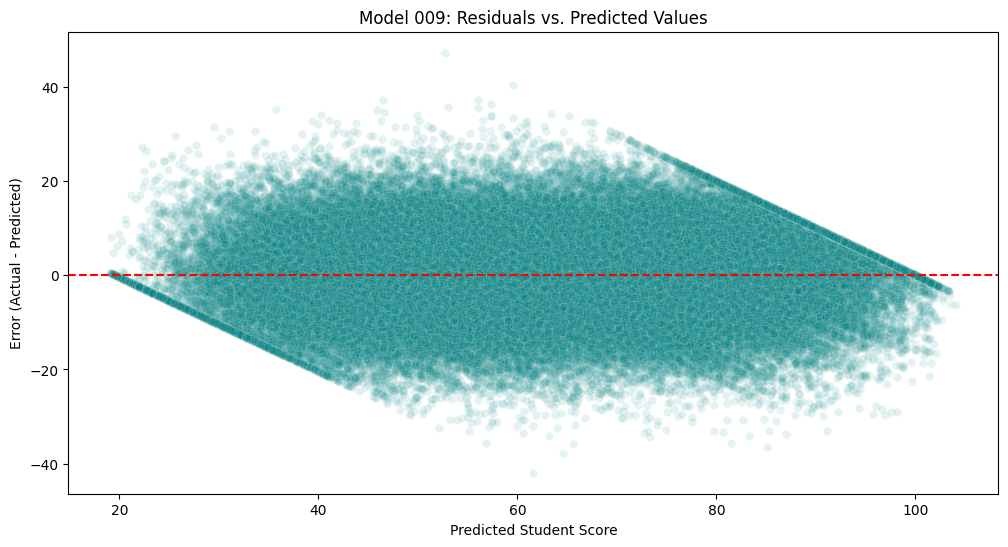

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get predictions from your Model 009 pipeline
val_preds = Final_pipe.predict(X_val)

# 2. Calculate Residuals (Actual - Predicted)
# Positive = Under-predicting | Negative = Over-predicting
residuals = y_val - val_preds

# 3. Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(x=val_preds, y=residuals, alpha=0.1, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.title("Model 009: Residuals vs. Predicted Values")
plt.xlabel("Predicted Student Score")
plt.ylabel("Error (Actual - Predicted)")
plt.show()

In [53]:
import pandas as pd

# Create a diagnostic dataframe
df_error = pd.DataFrame({'Actual': y_val, 'Pred': val_preds, 'Error': residuals})

# Check Average Error at the "100" spike
ceiling_error = df_error[df_error['Actual'] == 100]['Error'].mean()
# Check Average Error at the "20" spike
floor_error = df_error[df_error['Actual'] == 20]['Error'].mean()

print(f"Avg Under-prediction at Score 100: {ceiling_error:.2f}")
print(f"Avg Over-prediction at Score 20: {floor_error:.2f}")

Avg Under-prediction at Score 100: 8.72
Avg Over-prediction at Score 20: -12.87


In [18]:


param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.1, 0.05, 0.03],
    "max_iter": [200, 300, 500],
    "min_samples_leaf": [20, 50, 100]
}

Model = GridSearchCV(Model,
                    param_grid,
                    scoring='neg_root_mean_squared_error',
                    cv=3,
                    verbose=2,
                    n_jobs=-1)

In [ ]:
0.0008

In [ ]:
submission=pd.DataFrame({'id':raw_test_df['id'],
                         'exam_score':Model.predict(X_test)})

submission.to_csv("submission_004.csv", index=False)